# Lab 4.7: Classification Methods

- Original source: https://github.com/emredjan/ISL-python/blob/master/labs/lab_04.6_logistic_regression_lda_qda_knn.ipynb
- Added in ISLRv2:
  - 4.7.5 Naive Bayes
  - 4.7.7 Poisson Regression

## 4.7.1 The Stock Market Data

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")
%matplotlib inline

pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn') # pretty matplotlib plots

In [2]:
def make_prediction_summary(model, X):
    "Generate prediction summary of stock market models using predict_proba method."

    return pd.DataFrame(
        {
            "prob_0": model.predict_proba(X)[:, 0],
            "prob_1": model.predict_proba(X)[:, 1],
            "pred_class": model.predict(X),
        },
        columns=["prob_0", "prob_1", "pred_class"],
    )

In [3]:
# load data
smarket = pd.read_csv('../datasets/Smarket.csv', index_col=0)
smarket.Direction = smarket.Direction.astype('category')
smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.38,-0.19,-2.62,-1.05,5.01,1.19,0.96,Up
2,2001,0.96,0.38,-0.19,-2.62,-1.05,1.30,1.03,Up
3,2001,1.03,0.96,0.38,-0.19,-2.62,1.41,-0.62,Down
4,2001,-0.62,1.03,0.96,0.38,-0.19,1.28,0.61,Up
5,2001,0.61,-0.62,1.03,0.96,0.38,1.21,0.21,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.42,0.25,-0.02,-0.58,-0.28,1.89,0.04,Up
1247,2005,0.04,0.42,0.25,-0.02,-0.58,1.29,-0.95,Down
1248,2005,-0.95,0.04,0.42,0.25,-0.02,1.54,0.13,Up
1249,2005,0.13,-0.95,0.04,0.42,0.25,1.42,-0.30,Down


In [4]:
smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
smarket.shape

(1250, 9)

In [6]:
smarket.describe(include='all')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,"1,250.00","1,250.00","1,250.00","1,250.00","1,250.00","1,250.00","1,250.00","1,250.00",1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
mean,"2,003.02",0.00,0.00,0.00,0.00,0.01,1.48,0.00,NaN
std,1.41,1.14,1.14,1.14,1.14,1.15,0.36,1.14,NaN
min,"2,001.00",-4.92,-4.92,-4.92,-4.92,-4.92,0.36,-4.92,NaN
25%,"2,002.00",-0.64,-0.64,-0.64,-0.64,-0.64,1.26,-0.64,NaN
50%,"2,003.00",0.04,0.04,0.04,0.04,0.04,1.42,0.04,NaN
75%,"2,004.00",0.60,0.60,0.60,0.60,0.60,1.64,0.60,NaN


In [7]:
smarket.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 1250
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   int64   
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 89.3 KB


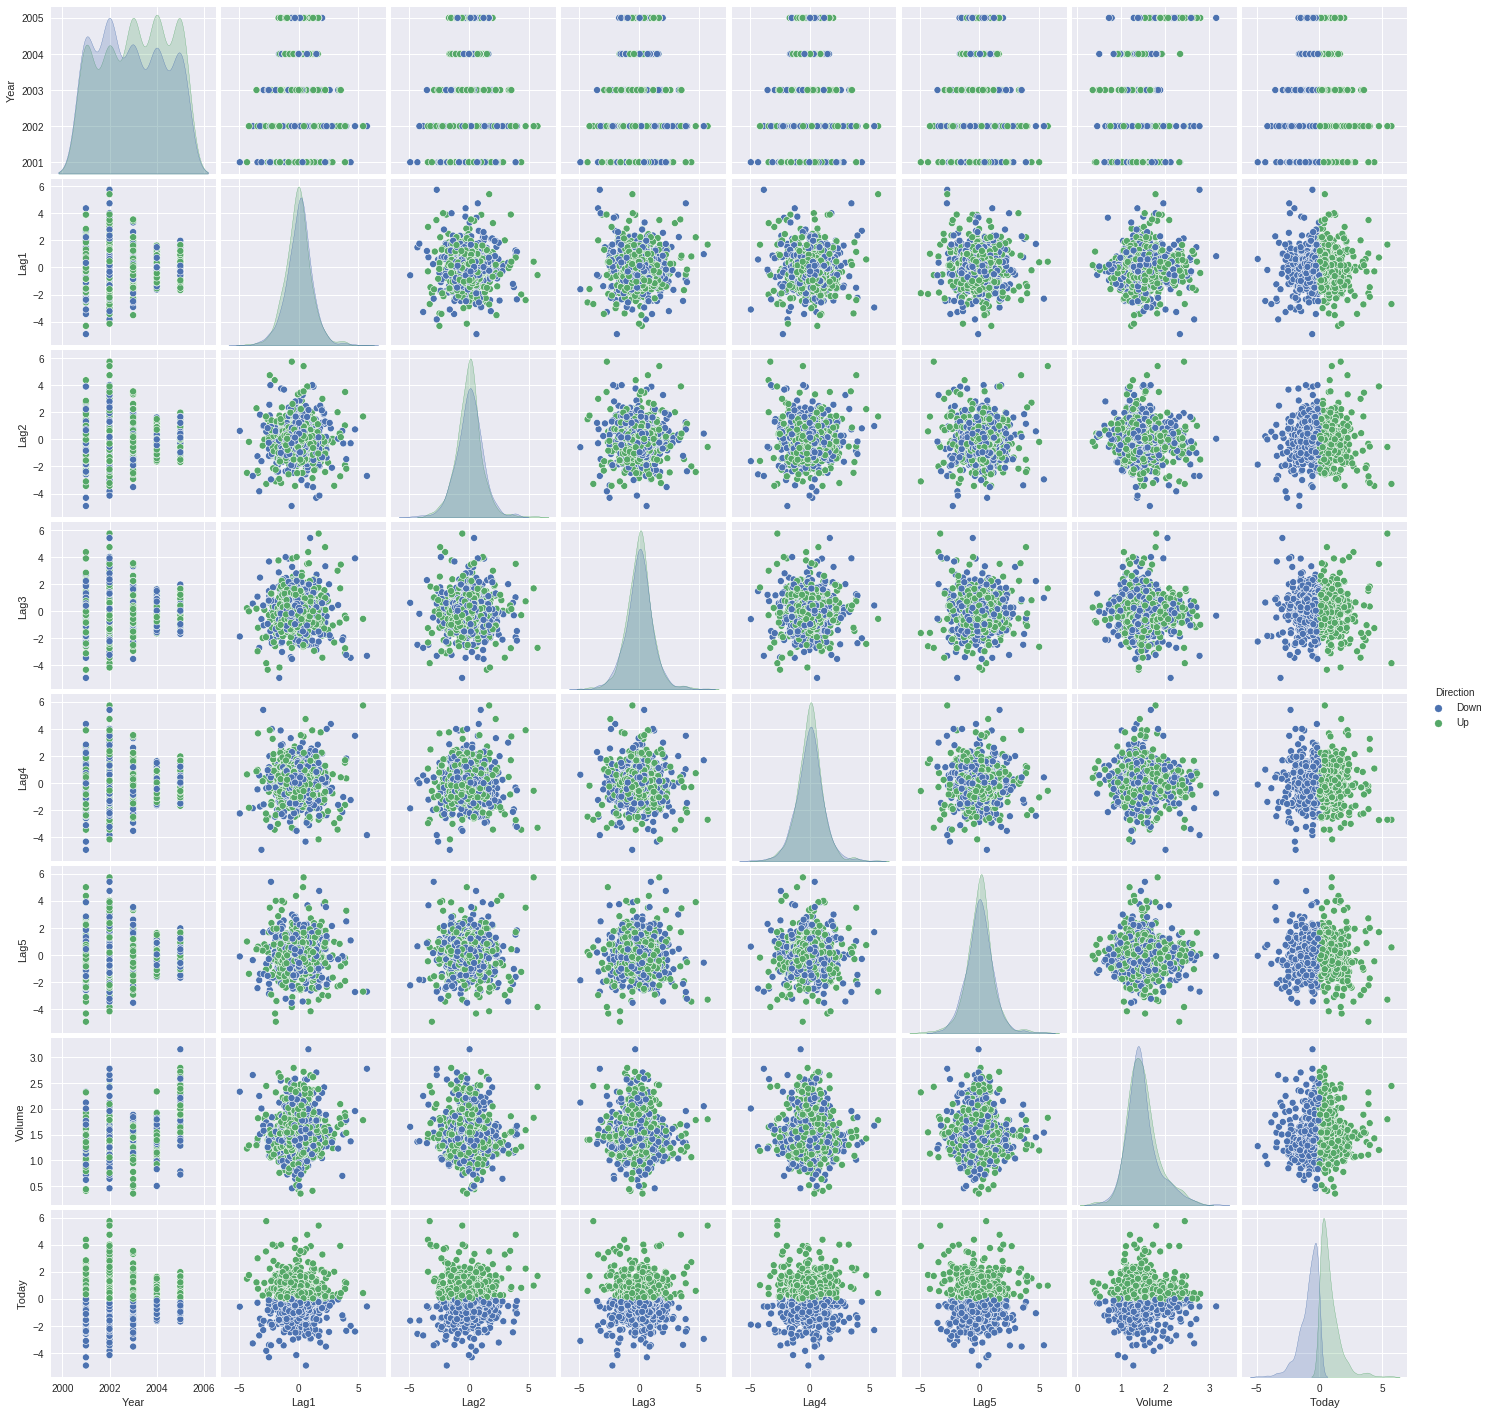

In [8]:
sns.pairplot(smarket, hue='Direction');

In [9]:
smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00,0.03,0.03,0.03,0.04,0.03,0.54,0.03
Lag1,0.03,1.00,-0.03,-0.01,-0.00,-0.01,0.04,-0.03
Lag2,0.03,-0.03,1.00,-0.03,-0.01,-0.00,-0.04,-0.01
Lag3,0.03,-0.01,-0.03,1.00,-0.02,-0.02,-0.04,-0.00
Lag4,0.04,-0.00,-0.01,-0.02,1.00,-0.03,-0.05,-0.01
Lag5,0.03,-0.01,-0.00,-0.02,-0.03,1.00,-0.02,-0.03
Volume,0.54,0.04,-0.04,-0.04,-0.05,-0.02,1.00,0.01
Today,0.03,-0.03,-0.01,-0.00,-0.01,-0.03,0.01,1.00


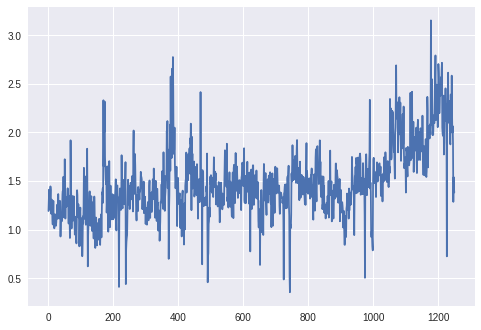

In [10]:
plt.plot(smarket.Volume);

## 4.7.2 Logistic Regression

### Using statsmodels

In [11]:
import statsmodels.api as sm

X_sm = smarket.loc[:,'Lag1':'Volume']
y_sm = pd.get_dummies(smarket.Direction).iloc[:, 1] # dummy encoding

glm_fit_sm = sm.Logit(y_sm, sm.add_constant(X_sm)).fit()
glm_fit_sm.summary()

Optimization terminated successfully.
         Current function value: 2.197001
         Iterations 4


/home/dkapitan/.local/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/dkapitan/.local/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     Up   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sun, 31 Oct 2021   Pseudo R-squ.:                     inf
Time:                        17:31:51   Log-Likelihood:                -2746.3
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [12]:
glm_fit_sm.predict()

array([0.50708413, 0.48146788, 0.48113883, ..., 0.5392683 , 0.52611829,
       0.51791656])

In [13]:
glm_fit_sm.pred_table()

array([[145., 457.],
       [141., 507.]])

### Using scikit-learn

In [14]:
from sklearn.linear_model import LogisticRegression

X_sk = smarket.loc[:,'Lag1':'Volume']
y_sk = smarket.Direction

glm_model = LogisticRegression(fit_intercept=True, C=1e9) # Large C for no regularization
glm_fit = glm_model.fit(X_sk, y_sk)

In [15]:
glm_fit.intercept_, glm_fit.coef_

(array([-0.12600781]),
 array([[-0.07307339, -0.04230074,  0.01108552,  0.00935968,  0.01031339,
          0.13544567]]))

In [16]:


make_prediction_summary(glm_fit, X_sk)

,prob_0,prob_1,pred_class
0,0.49,0.51,Up
1,0.52,0.48,Down
2,0.52,0.48,Down
3,0.48,0.52,Up
4,0.49,0.51,Up
...,...,...,...
1245,0.48,0.52,Up
1246,0.49,0.51,Up
1247,0.46,0.54,Up
1248,0.47,0.53,Up


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

# labeled confusion matrix for predicted values
conf_m = pd.DataFrame(confusion_matrix(y_sk, glm_fit.predict(X_sk)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,145,457
1,141,507


In [18]:
print('Accuracy: ' + str(accuracy_score(y_sk, glm_fit.predict(X_sk))))
print('Training Error: ' + str(1 - accuracy_score(y_sk, glm_fit.predict(X_sk))))

Accuracy: 0.5216
Training Error: 0.47840000000000005


In [19]:
# separate training and test sets
train = smarket.loc[smarket.Year < 2005]
smarket_2005 = smarket.loc[smarket.Year >= 2005]

In [20]:
X_sk_train = train.loc[:,'Lag1':'Volume']
y_sk_train = train.Direction

X_sk_test = smarket_2005.loc[:,'Lag1':'Volume']
y_sk_test = smarket_2005.Direction

glm_model_t = LogisticRegression(fit_intercept=True, C=1e9) # Large C for no regularization
glm_fit_t = glm_model.fit(X_sk_train, y_sk_train)

In [21]:
make_prediction_summary(glm_fit_t, X_sk_test)

,prob_0,prob_1,pred_class
0,0.47,0.53,Up
1,0.48,0.52,Up
2,0.48,0.52,Up
3,0.49,0.51,Up
4,0.50,0.50,Down
...,...,...,...
247,0.52,0.48,Down
248,0.49,0.51,Up
249,0.48,0.52,Up
250,0.48,0.52,Up


In [22]:
conf_m = pd.DataFrame(confusion_matrix(y_sk_test, glm_fit.predict(X_sk_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,77,34
1,97,44


In [23]:
print('Accuracy: ' + str(accuracy_score(y_sk_test, glm_fit.predict(X_sk_test))))
print('Test Error: ' + str(1 - accuracy_score(y_sk_test, glm_fit.predict(X_sk_test))))

Accuracy: 0.4801587301587302
Test Error: 0.5198412698412698


In [24]:
X_sk_train_s = train.loc[:,'Lag1':'Lag2']
y_sk_train_s = train.Direction

X_sk_test_s = smarket_2005.loc[:,'Lag1':'Lag2']
y_sk_test_s = smarket_2005.Direction

glm_model_t_s = LogisticRegression(fit_intercept=True, C=1e9) # Large C for no regularization
glm_fit_t_s = glm_model.fit(X_sk_train_s, y_sk_train_s)

In [28]:
make_prediction_summary(glm_fit_t_s, X_sk_test_s)

,prob_0,prob_1,pred_class
0,0.49,0.51,Up
1,0.48,0.52,Up
2,0.47,0.53,Up
3,0.47,0.53,Up
4,0.49,0.51,Up
...,...,...,...
247,0.50,0.50,Down
248,0.50,0.50,Up
249,0.48,0.52,Up
250,0.48,0.52,Up


In [29]:
conf_m = pd.DataFrame(confusion_matrix(y_sk_test_s, glm_fit.predict(X_sk_test_s)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,35,76
1,35,106


In [30]:
print('Accuracy: ' + str(accuracy_score(y_sk_test_s, glm_fit.predict(X_sk_test_s))))
print('Test Error: ' + str(1 - accuracy_score(y_sk_test_s, glm_fit.predict(X_sk_test_s))))

Accuracy: 0.5595238095238095
Test Error: 0.44047619047619047


In [31]:
# predictions for arbitrary data
predict_data = pd.DataFrame({'Lag1': [1.2, 1.5], 'Lag2': [1.1, -0.8]})
glm_fit.predict_proba(predict_data)[:, 1]

array([0.47914604, 0.49611109])

## 4.7.3 Linear Discriminant Analysis

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train = train.loc[:,'Lag1':'Lag2']
y_train = train.Direction

X_test = smarket_2005.loc[:,'Lag1':'Lag2']
y_test = smarket_2005.Direction

lda_model = LinearDiscriminantAnalysis()
lda_fit = lda_model.fit(X_train, y_train)

In [33]:
lda_fit.priors_ # group priors

array([0.49198397, 0.50801603])

In [34]:
lda_fit.means_ # group means

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [35]:
lda_fit.scalings_ # coefficients of ld

array([[-0.64201904],
       [-0.51352928]])

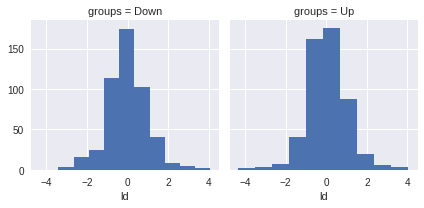

In [36]:
# for plotting lda, needs imporovement
ld_sc = X_train.iloc[:, 0] * lda_fit.scalings_[0] + X_train.iloc[:, 1] * lda_fit.scalings_[1]

ld = pd.DataFrame({'groups': y_train, 'ld': ld_sc})

g = sns.FacetGrid(ld, col='groups')
g.map(plt.hist, 'ld');

In [37]:
# prediction summary
pd.DataFrame({'prob_0': lda_fit.predict_proba(X_test)[:, 0], 
              'prob_1': lda_fit.predict_proba(X_test)[:, 1], 
              'pred_class': lda_fit.predict(X_test)}, 
             columns=['prob_0', 'prob_1', 'pred_class'])

,prob_0,prob_1,pred_class
0,0.49,0.51,Up
1,0.48,0.52,Up
2,0.47,0.53,Up
3,0.47,0.53,Up
4,0.49,0.51,Up
...,...,...,...
247,0.50,0.50,Down
248,0.50,0.50,Up
249,0.48,0.52,Up
250,0.48,0.52,Up


In [38]:
conf_m = pd.DataFrame(confusion_matrix(y_test, glm_fit.predict(X_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,35,76
1,35,106


## 4.7.4 Quadratic Discriminant Analysis

In [39]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train = train.loc[:,'Lag1':'Lag2']
y_train = train.Direction

X_test = smarket_2005.loc[:,'Lag1':'Lag2']
y_test = smarket_2005.Direction

qda_model = QuadraticDiscriminantAnalysis()
qda_fit = qda_model.fit(X_train, y_train)

In [40]:
qda_fit.priors_ # group priors

array([0.49198397, 0.50801603])

In [41]:
qda_fit.means_ # group means

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [42]:
qda_fit.scalings_ # coefficients of ld

[array([1.56294495, 1.47927279]), array([1.53455065, 1.47272326])]

In [43]:
# prediction summary
pd.DataFrame({'prob_0': qda_fit.predict_proba(X_test)[:, 0], 
              'prob_1': qda_fit.predict_proba(X_test)[:, 1], 
              'pred_class': qda_fit.predict(X_test)}, 
             columns=['prob_0', 'prob_1', 'pred_class'])

,prob_0,prob_1,pred_class
0,0.49,0.51,Up
1,0.48,0.52,Up
2,0.46,0.54,Up
3,0.47,0.53,Up
4,0.49,0.51,Up
...,...,...,...
247,0.50,0.50,Up
248,0.49,0.51,Up
249,0.48,0.52,Up
250,0.48,0.52,Up


In [44]:
conf_m = pd.DataFrame(confusion_matrix(y_test, qda_fit.predict(X_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,30,81
1,20,121


In [56]:
print(f'Accuracy: {accuracy_score(y_test, qda_fit.predict(X_test)):.3f}')
print(f'Test Error: {1 - accuracy_score(y_test, qda_fit.predict(X_test)):.3f}')

Accuracy: 0.599
Test Error: 0.401


## 4.7.5 Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

X_train = train.loc[:,'Lag1':'Lag2']
y_train = train.Direction

X_test = smarket_2005.loc[:,'Lag1':'Lag2']
y_test = smarket_2005.Direction

nb_model = GaussianNB()
nb_fit = nb_model.fit(X_train, y_train)

In [48]:
make_prediction_summary(nb_fit, X_test)

,prob_0,prob_1,pred_class
0,0.49,0.51,Up
1,0.48,0.52,Up
2,0.47,0.53,Up
3,0.47,0.53,Up
4,0.49,0.51,Up
...,...,...,...
247,0.50,0.50,Up
248,0.49,0.51,Up
249,0.48,0.52,Up
250,0.48,0.52,Up


In [55]:
print(f'Accuracy: {accuracy_score(y_test, nb_fit.predict(X_test)):.3f}')
print(f'Test Error: {1 - accuracy_score(y_test, nb_fit.predict(X_test)):.3f}')

Accuracy: 0.595
Test Error: 0.405


## 4.7.6 K-Nearest Neighbors

### Stock market data

In [58]:
from sklearn.neighbors import KNeighborsClassifier

X_train = train.loc[:,'Lag1':'Lag2']
y_train = train.Direction

X_test = smarket_2005.loc[:,'Lag1':'Lag2']
y_test = smarket_2005.Direction

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_fit = knn_model.fit(X_train, y_train)

In [59]:
make_prediction_summary(knn_fit, X_test)

,prob_0,prob_1,pred_class
0,0.00,1.00,Up
1,1.00,0.00,Down
2,0.00,1.00,Up
3,0.00,1.00,Up
4,0.00,1.00,Up
...,...,...,...
247,1.00,0.00,Down
248,1.00,0.00,Down
249,0.00,1.00,Up
250,1.00,0.00,Down


In [60]:
conf_m = pd.DataFrame(confusion_matrix(y_test, knn_fit.predict(X_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,43,68
1,58,83


In [61]:
print('Accuracy: ' + str(accuracy_score(y_test, knn_fit.predict(X_test))))
print('Test Error: ' + str(1 - accuracy_score(y_test, knn_fit.predict(X_test))))

Accuracy: 0.5
Test Error: 0.5


In [62]:
knn_model_3 = KNeighborsClassifier(n_neighbors=3)
knn_fit_3 = knn_model_3.fit(X_train, y_train)

In [63]:
conf_m = pd.DataFrame(confusion_matrix(y_test, knn_fit_3.predict(X_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,48,63
1,55,86


In [65]:
print(f'Accuracy: {accuracy_score(y_test, knn_fit_3.predict(X_test)):.3f}')
print(f'Test Error: {1 - accuracy_score(y_test, knn_fit_3.predict(X_test)):.3f}')

Accuracy: 0.532
Test Error: 0.468


### Caravan insurance data

In [66]:
# load data
caravan = pd.read_csv('../datasets/Caravan.csv', index_col=0)
caravan.Purchase = caravan.Purchase.astype('category')
caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5819,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5820,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5821,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


In [67]:
caravan.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 1 to 5822
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MOSTYPE   5822 non-null   int64   
 1   MAANTHUI  5822 non-null   int64   
 2   MGEMOMV   5822 non-null   int64   
 3   MGEMLEEF  5822 non-null   int64   
 4   MOSHOOFD  5822 non-null   int64   
 5   MGODRK    5822 non-null   int64   
 6   MGODPR    5822 non-null   int64   
 7   MGODOV    5822 non-null   int64   
 8   MGODGE    5822 non-null   int64   
 9   MRELGE    5822 non-null   int64   
 10  MRELSA    5822 non-null   int64   
 11  MRELOV    5822 non-null   int64   
 12  MFALLEEN  5822 non-null   int64   
 13  MFGEKIND  5822 non-null   int64   
 14  MFWEKIND  5822 non-null   int64   
 15  MOPLHOOG  5822 non-null   int64   
 16  MOPLMIDD  5822 non-null   int64   
 17  MOPLLAAG  5822 non-null   int64   
 18  MBERHOOG  5822 non-null   int64   
 19  MBERZELF  5822 non-null   int64   
 20  MBERBOER

In [68]:
caravan.Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [69]:
caravan.Purchase.value_counts()['Yes']/len(caravan)

0.05977327378907592

In [70]:
from scipy.stats import zscore

X = caravan.iloc[:, 0:85].apply(zscore) # standardize for KNN
y = caravan.Purchase

X_train = X.loc[1001:]
y_train = y.loc[1001:]

X_test = X.loc[:1000]
y_test = y.loc[:1000]

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_fit = knn_model.fit(X_train, y_train)

In [71]:
conf_m = pd.DataFrame(confusion_matrix(y_test, knn_fit.predict(X_test)))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,873,68
1,50,9


In [74]:
print(f'Accuracy: {accuracy_score(y_test, knn_fit.predict(X_test)):.3f}')
print(f'Test Error: {1 - accuracy_score(y_test, knn_fit.predict(X_test)):.3f}')

Accuracy: 0.882
Test Error: 0.118


In [75]:
from sklearn.metrics import precision_score

print('Precision for \'Yes\': ' + str(precision_score(y_test, knn_fit.predict(X_test), pos_label='Yes')))

Precision for 'Yes': 0.11688311688311688


In [76]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_fit3 = knn_model.fit(X_train, y_train)

print('Precision for \'Yes\': ' + str(precision_score(y_test, knn_fit3.predict(X_test), pos_label='Yes')))

Precision for 'Yes': 0.2


In [77]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_fit5 = knn_model.fit(X_train, y_train)

print('Precision for \'Yes\': ' + str(precision_score(y_test, knn_fit5.predict(X_test), pos_label='Yes')))

Precision for 'Yes': 0.26666666666666666


In [78]:
glm_model = LogisticRegression(fit_intercept=True, C=1e9) # Large C for no regularization
glm_fit = glm_model.fit(X_train, y_train)

In [79]:
glm_pred_50 = pd.Series(glm_fit.predict_proba(X_test)[:, 1] > 0.5).map({False: 'No', True: 'Yes'})

conf_m = pd.DataFrame(confusion_matrix(y_test, glm_pred_50))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,935,6
1,59,0


In [80]:
print('Precision for \'Yes\': ' + str(precision_score(y_test, glm_pred_50, pos_label='Yes')))

Precision for 'Yes': 0.0


In [81]:
glm_pred_25 = pd.Series(glm_fit.predict_proba(X_test)[:, 1] > 0.25).map({False: 'No', True: 'Yes'})

conf_m = pd.DataFrame(confusion_matrix(y_test, glm_pred_25))
conf_m.columns.name = 'Predicted'
conf_m.index.name = 'True'
conf_m

Predicted,0,1
True,,
0,918,23
1,48,11


In [82]:
print('Precision for \'Yes\': ' + str(precision_score(y_test, glm_pred_25, pos_label='Yes')))

Precision for 'Yes': 0.3235294117647059


## 4.7.7 Poisson Regression